# Project: Applied Machine Learning 
This notebook was created by Lennart Onghena, Roel Moeyersoons and Tim De Smet. 

This project is a collaboration with ML6. They are launching a product that automates parts of big email inboxes.

# 1. Exploratory Data Analysis (EDA)

## 1.1. The Data

The features of the data are explained [here](https://cfpb.github.io/api/ccdb/fields.html) 

In [13]:
# All imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix 
from sklearn.decomposition import TruncatedSVD

#%matplotlib inline

In [2]:
# Use pandas to read csv data into DataFrame
complaints = pd.read_csv('complaints-2020-01-22_08_24.csv')

Usinge the .info() function the DataFrame we can determine the following about the data:
* There are a total of 485701 complaints
* There are a total of 18 features, one of which is numeric
* There are no missing values, so we don't have to eliminate these datapoints 

In [3]:
complaints.info()
complaints.head(1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 485701 entries, 0 to 485700
Data columns (total 18 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   Date received                 485701 non-null  object
 1   Product                       485701 non-null  object
 2   Sub-product                   485701 non-null  object
 3   Issue                         485701 non-null  object
 4   Sub-issue                     485701 non-null  object
 5   Consumer complaint narrative  485701 non-null  object
 6   Company public response       485701 non-null  object
 7   Company                       485701 non-null  object
 8   State                         485701 non-null  object
 9   ZIP code                      485701 non-null  object
 10  Tags                          485701 non-null  object
 11  Consumer consent provided?    485701 non-null  object
 12  Submitted via                 485701 non-null  object
 13 

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,07/23/19,"Credit reporting, credit repair services, or o...",Credit reporting,Credit monitoring or identity theft protection...,Problem canceling credit monitoring or identif...,I have complained many times that the credit r...,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,CA,926XX,None,Consent provided,Web,07/23/19,Closed with explanation,Yes,NaN,3315279


First of all, let's check how many complains every product has received

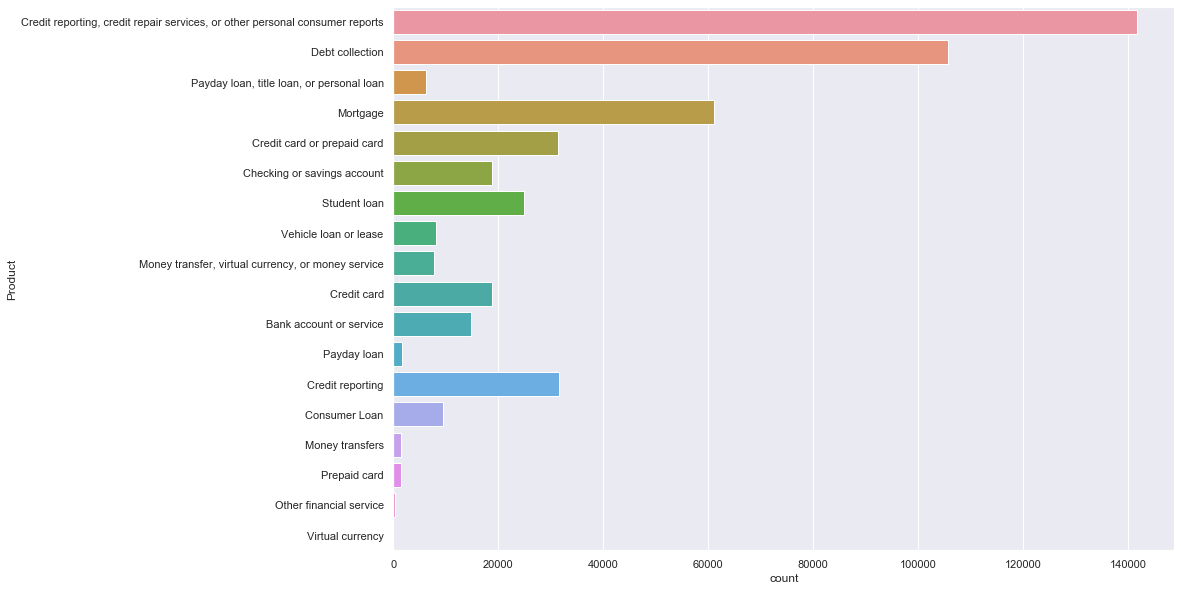

In [7]:
# Visual representation of the amount of complaints related to certain products
plt.figure(figsize=(14,10))
sns.set()
sns.countplot(y='Product', data=complaints)
plt.show()

These are the amount of complaints received about the different products and subproducts:

In [8]:
temp = complaints['Product'].value_counts();

for i in range(len(temp)):
    print(f'\n{temp.index[i]}: {temp[i]}')
    temp2 = (complaints[complaints['Product'] == temp.index[i]]['Sub-product'].value_counts())
    for j in range(len(temp2)):
            print(f'\t\t{temp2.index[j]}: {temp2[j]}')


Credit reporting, credit repair services, or other personal consumer reports: 141742
		Credit reporting: 138534
		Other personal consumer report: 2481
		Credit repair services: 726
		Conventional home mortgage: 1

Debt collection: 105765
		I do not know: 20639
		Other debt: 18699
		Credit card debt: 14522
		Other (i.e. phone, health club, etc.): 12389
		Medical debt: 11239
		Credit card: 7520
		Medical: 6990
		Payday loan debt: 2461
		Auto debt: 2319
		Payday loan: 2064
		Mortgage debt: 1500
		Federal student loan debt: 1126
		Private student loan debt: 1093
		Auto: 1064
		Mortgage: 907
		Non-federal student loan: 684
		Federal student loan: 549

Mortgage: 61094
		Conventional home mortgage: 17063
		Conventional fixed mortgage: 14562
		FHA mortgage: 11341
		Conventional adjustable mortgage (ARM): 4975
		VA mortgage: 3437
		Other mortgage: 3236
		Home equity loan or line of credit: 2103
		Other type of mortgage: 2011
		Home equity loan or line of credit (HELOC): 1690
		Reverse mortgage

Let's look at the Product "Debt Collection" in particular:


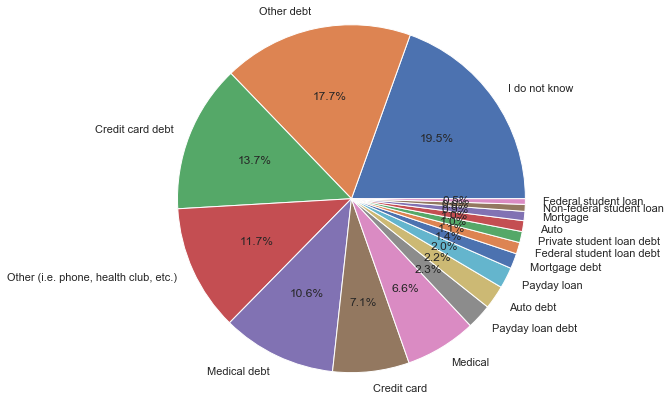

In [47]:
products = complaints["Product"].unique()

debt = complaints[complaints["Product"] == "Debt collection"]
subProdCount = debt["Sub-product"].value_counts()#[:10]

#plt.title("Debt Collection")
patches, texts, autotexts = plt.pie(subProdCount.values, labels = subProdCount.index, radius = 2, autopct="%.1f%%",)
for t in autotexts:
    t.set_fontsize(12)
plt.show()

To better see the distribution of Sub-Products, the above is also shown in pie plots 

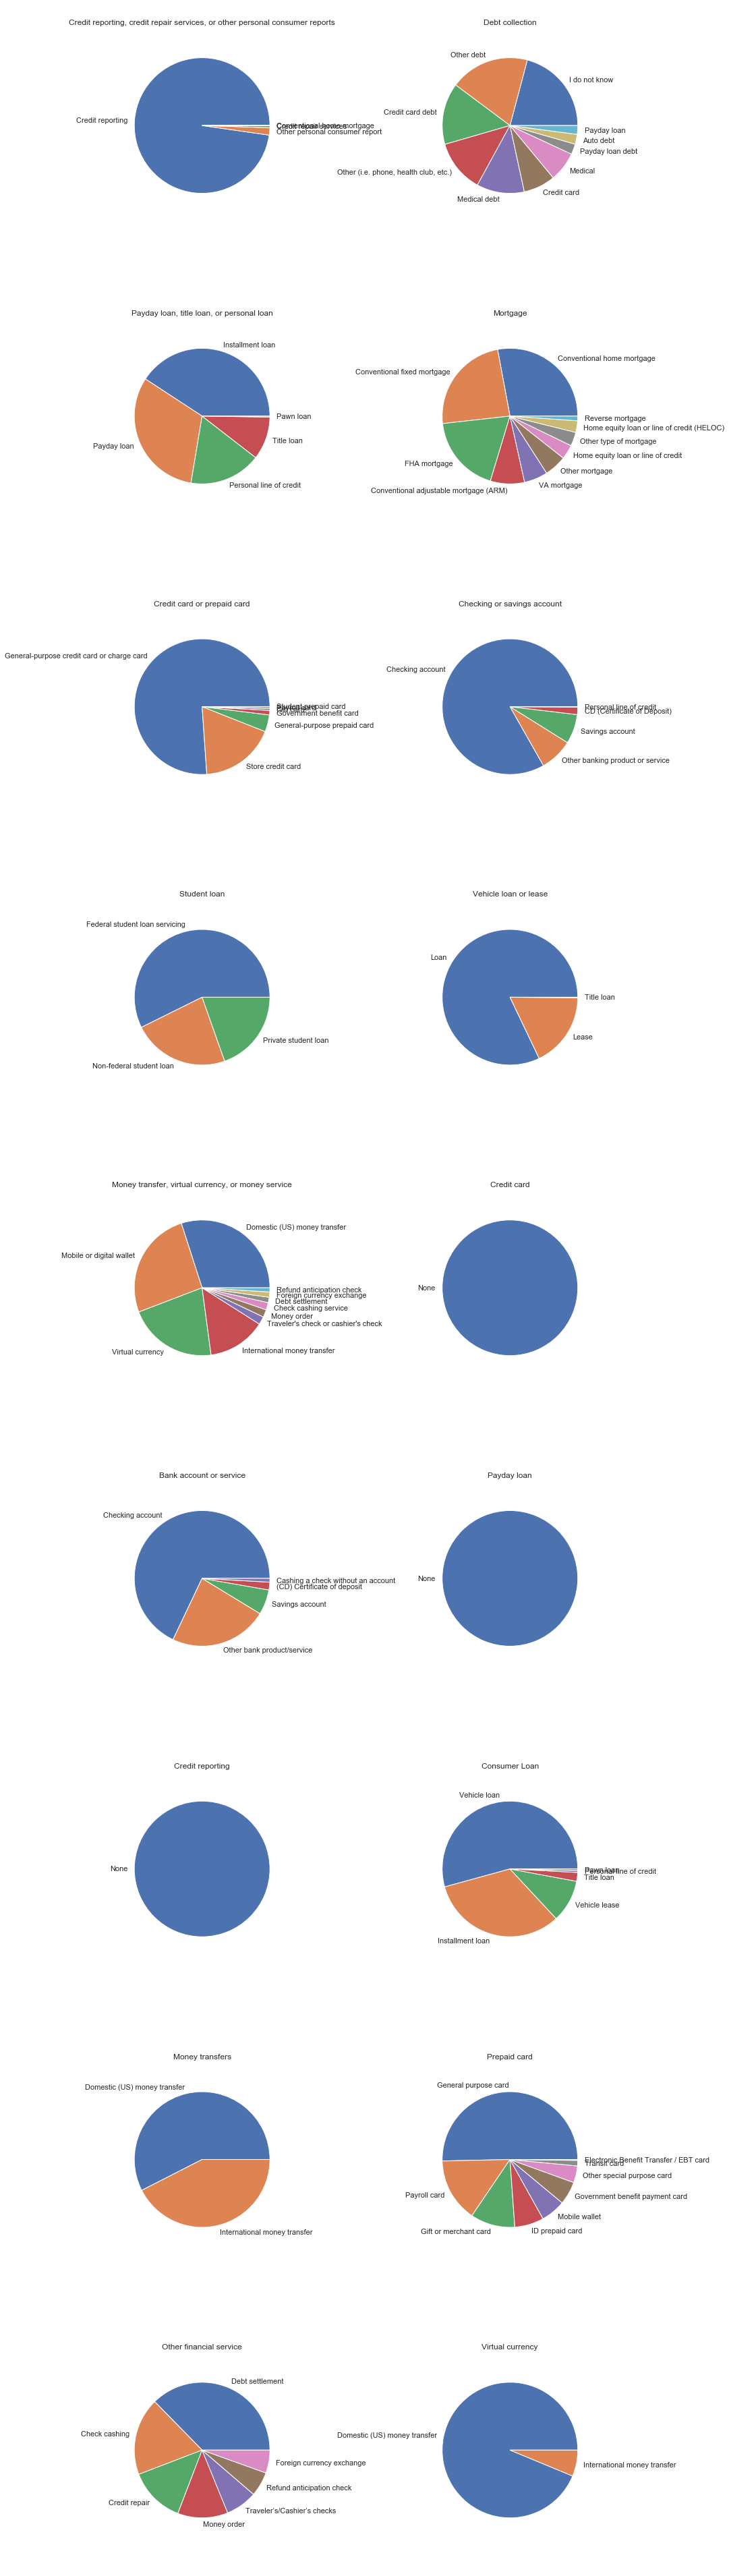

In [36]:
products = complaints["Product"].unique()
names = [x for x in products]

fig = plt.figure(figsize = (15,70))
#plt.rcParams.update({'font.size': 22})
#fig.subplots_adjust(hspace=0.1, wspace=0.3)
i = 0
for n in names:
    i = i + 1
    subplt = fig.add_subplot(9,2,i)
    subplt.set_title(n, y=0.9)
    x = complaints[complaints["Product"] == n]
    counts = x["Sub-product"].value_counts()[:10]
    plt.pie(counts.values, labels = counts.index, radius=0.7)
plt.show()

The distributions of the sub-issues for each issue are the following:

In [5]:
temp = complaints['Issue'].value_counts();

for i in range(len(temp)):
    print(f'\n{temp.index[i]}: {temp[i]}')
    temp2 = (complaints[complaints['Issue'] == temp.index[i]]['Sub-issue'].value_counts())
    for j in range(len(temp2)):
            print(f'\t\t{temp2.index[j]}: {temp2[j]}')


Incorrect information on your report: 77776
		Information belongs to someone else: 32324
		Account status incorrect: 15559
		Account information incorrect: 15060
		Old information reappears or never goes away: 4282
		Personal information incorrect: 4058
		Public record information inaccurate: 3900
		Information is missing that should be on the report: 1726
		None: 512
		Information is incorrect: 298
		Information that should be on the report is missing: 57

Problem with a credit reporting company's investigation into an existing problem: 38424
		Their investigation did not fix an error on your report: 27394
		Investigation took more than 30 days: 3027
		Difficulty submitting a dispute or getting information about a dispute over the phone: 2877
		Was not notified of investigation status or results: 2616
		Problem with personal statement of dispute: 2317
		None: 193

Attempts to collect debt not owed: 28629
		Debt is not yours: 14708
		Debt was paid: 6413
		Debt was result of identity t

		Didn't receive advertised or promotional terms: 1452
		Confusing or misleading advertising about the credit card: 947

Closing an account: 2379
		Company closed your account: 1022
		Funds not received from closed account: 581
		Can't close your account: 572
		Fees charged for closing account: 204

Unable to get credit report/credit score: 2252
		Problem getting my free annual report: 1214
		Problem getting report or credit score: 1038

Settlement process and costs: 2250
		None: 2250

Credit monitoring or identity theft protection services: 2223
		Billing dispute for services: 874
		Problem canceling credit monitoring or identify theft protection service: 474
		Didn't receive services that were advertised: 380
		Problem with product or service terms changing: 352
		Received unwanted marketing or advertising: 121
		None: 22

Opening an account: 2208
		Didn't receive terms that were advertised: 1063
		Unable to open an account: 661
		Account opened as a result of fraud: 351
		Confusing 

		None: 95

Adding money: 92
		None: 92

Money was taken from your bank account on the wrong day or for the wrong amount: 92
		None: 92

Problem adding money: 85
		None: 85

Applied for loan/did not receive money: 85
		None: 85

Forbearance / Workout plans: 85
		None: 85

Arbitration: 83
		None: 83

Excessive fees: 81
		None: 81

Advertising: 77
		Confusing or misleading advertising about the card: 59
		Changes in terms from what was offered or advertised: 18

Fees: 77
		None: 77

Was approved for a loan, but didn't receive the money: 65
		None: 65

Lost or stolen check: 64
		None: 64

Incorrect/missing disclosures or info: 58
		None: 58

Lost or stolen money order: 56
		None: 56

Customer service/Customer relations: 55
		None: 55

Balance transfer fee: 51
		None: 51

Cash advance: 44
		None: 44

Cash advance fee: 41
		None: 41

Convenience checks: 37
		None: 37

Vehicle was damaged or destroyed the vehicle: 36
		None: 36

Credit limit changed: 31
		None: 31

Overlimit fee: 31
		None: 

Let's visualize the issues by product:

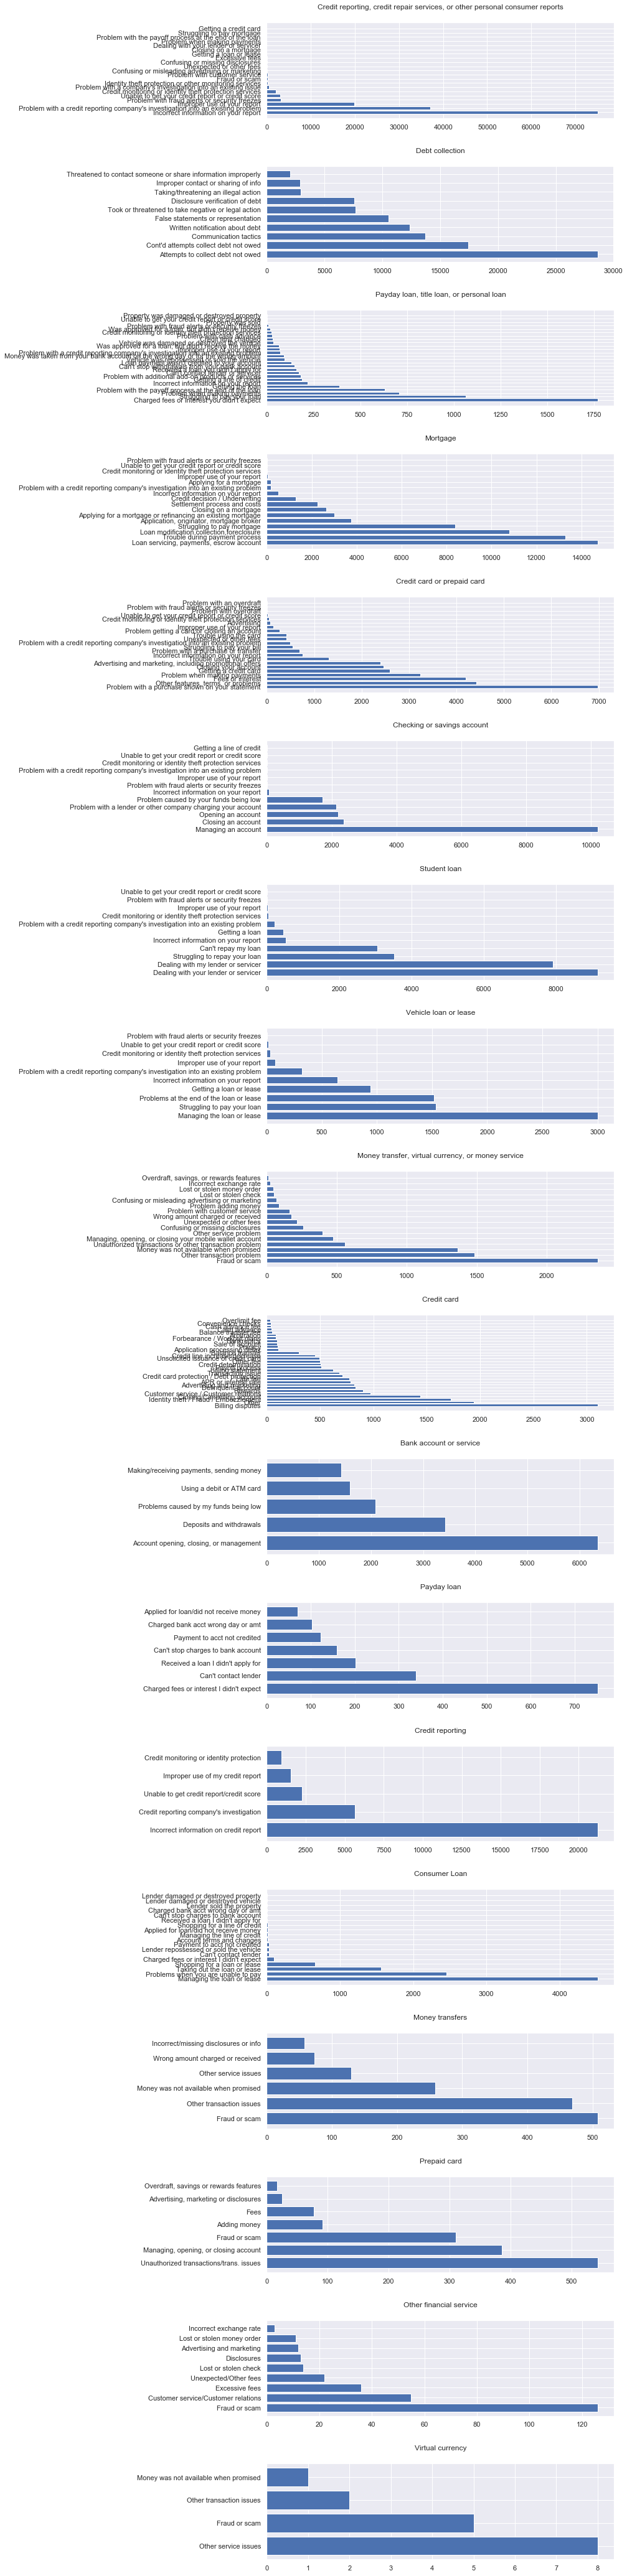

In [54]:
products = complaints["Product"].unique()
names = [x for x in products]

fig = plt.figure(figsize = (10,75))
#plt.rcParams.update({'font.size': 26})
fig.subplots_adjust(hspace=0.5)
i = 0
for n in names:
    i = i + 1
    ax = fig.add_subplot(18,1,i)
    ax.set_title(n, y=1.1)
    x = complaints[complaints["Product"] == n]
    counts = x["Issue"].value_counts()

    y_pos = np.arange(len(counts))
    ax.barh(y_pos, counts.values, align='center')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(counts.index)
    
plt.show()

As seen above, some issues appear in several products. Below the issues are printed along with each product category it appears in

In [55]:
temp = complaints['Issue'].value_counts();

for i in range(len(temp)):
    print(f'\n{temp.index[i]}: {temp[i]}')
    temp2 = (complaints[complaints['Issue'] == temp.index[i]]['Product'].value_counts())
    for j in range(len(temp2)):
            print(f'\t\t{temp2.index[j]}: {temp2[j]}')


Incorrect information on your report: 77776
		Credit reporting, credit repair services, or other personal consumer reports: 75050
		Credit card or prepaid card: 761
		Vehicle loan or lease: 639
		Student loan: 531
		Mortgage: 511
		Payday loan, title loan, or personal loan: 219
		Checking or savings account: 65

Problem with a credit reporting company's investigation into an existing problem: 38424
		Credit reporting, credit repair services, or other personal consumer reports: 37107
		Credit card or prepaid card: 496
		Vehicle loan or lease: 317
		Student loan: 223
		Mortgage: 193
		Payday loan, title loan, or personal loan: 72
		Checking or savings account: 16

Attempts to collect debt not owed: 28629
		Debt collection: 28629

Incorrect information on credit report: 21217
		Credit reporting: 21217

Improper use of your report: 20239
		Credit reporting, credit repair services, or other personal consumer reports: 19878
		Credit card or prepaid card: 132
		Vehicle loan or lease: 74
		Pa

		Prepaid card: 543

Payoff process: 513
		Credit card: 513

Credit determination: 506
		Credit card: 506

Other fee: 502
		Credit card: 502

Unsolicited issuance of credit card: 491
		Credit card: 491

Managing, opening, or closing your mobile wallet account: 473
		Money transfer, virtual currency, or money service: 473

Other transaction issues: 471
		Money transfers: 469
		Virtual currency: 2

Getting a loan: 465
		Student loan: 465

Credit line increase/decrease: 451
		Credit card: 451

Problem with a company's investigation into an existing issue: 447
		Credit reporting, credit repair services, or other personal consumer reports: 447

Trouble using the card: 412
		Credit card or prepaid card: 412

Other service problem: 399
		Money transfer, virtual currency, or money service: 399

Getting the loan: 389
		Payday loan, title loan, or personal loan: 389

Managing, opening, or closing account: 386
		Prepaid card: 386

Can't contact lender: 372
		Payday loan: 339
		Consumer Loan: 33



## 1.2. Problems

* Sub-product and Sub-issue not always present
* Product columns are overlapping, we could change to:        
    * Mortgage (cat A)
    * Loan (cat B)
        * Consumer Loan
        * Payday loan
        * Payday loan, title loan, or personal loan
        * Student loan
        * Vehicle loan or lease
    * Card (cat C)
        * Credit card
        * Credit card or prepaid card
        * Prepaid card
    * Credit (cat D)
        * Credit reporting
        * Credit reporting, credit repair services, or other personal consumer reports
    * Other financial service (cat E)
        * Money transfer, virtual currency, or money service
        * Money transfers
        * Virtual currency
        * Bank account or service
        * Checking or savings account
    * Debt collection (cat F)
* Also overlap between issues 
* Some Products have the same issue names

In the first iteration we are going to
* remove seemingly unnecessairy data and simplify dataset
* Extract features
* One hot encoding for categorical features
* remove imbalances
* pairplot
* catplot
* train test split

* Classify incoming messages to some basic issue types

## 1.3. Simplification

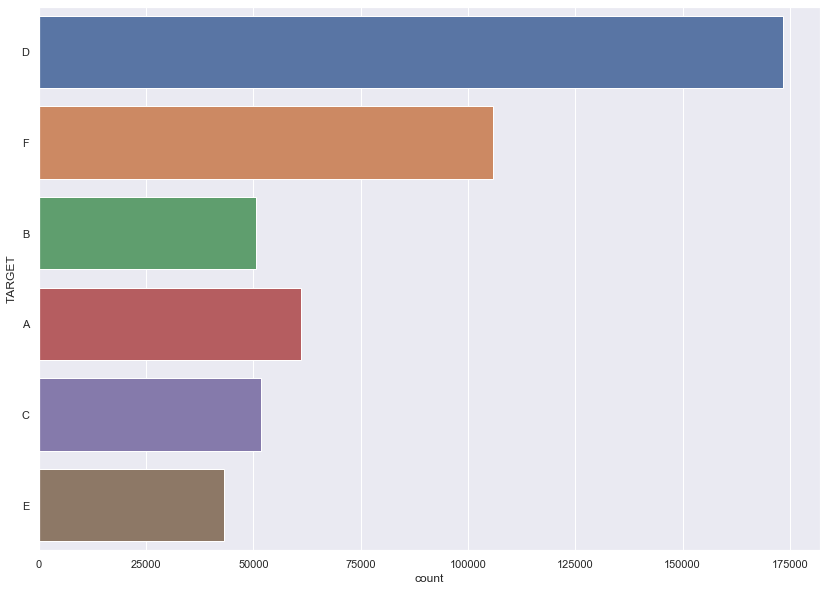

In [44]:
# simplifying dataset
simp_map = {
    'Debt collection' : 'F', 
    'Payday loan' : 'B', 
    'Mortgage' : 'A', 
    'Bank account or service' : 'E', 
    'Consumer Loan' : 'B', 
    'Other financial service' : 'E', 
    'Vehicle loan or lease' : 'B',
    'Payday loan, title loan, or personal loan' : 'B', 
    'Money transfers' : 'E', 
    'Student loan' : 'B', 
    'Virtual currency': 'E', 
    'Credit reporting, credit repair services, or other personal consumer reports' : 'D', 
    'Credit card' : 'C', 
    'Checking or savings account' : 'E', 
    'Prepaid card' : 'C', 
    'Money transfer, virtual currency, or money service' : 'E', 
    'Credit reporting': 'D', 
    'Credit card or prepaid card' : 'C'}

data = complaints[['Product', 'Consumer complaint narrative']].copy()
data['TARGET'] = data['Product'].map(simp_map)

plt.figure(figsize=(14,10))
sns.set()
sns.countplot(y='TARGET', data=data)
plt.show()

We can see that the dataset is imbalanced, this could cause the model to collapse to the trivial solution of always returning the same prediction. We will resolve this by subsampling in order to flatten the distribution:

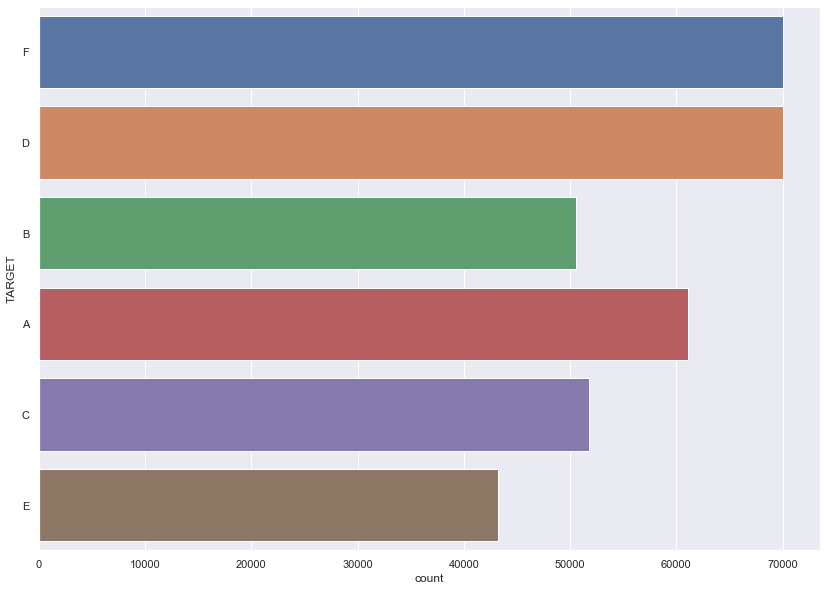

In [46]:
for c in ['A', 'B', 'C', 'D', 'E', 'F']:
    if data[data['TARGET'] == c].shape[0] > 70000:
        data = pd.concat(objs=[data[data['TARGET'] == c].sample(n=70000), data[data['TARGET'] != c]])

plt.figure(figsize=(14,10))
sns.set()
sns.countplot(y='TARGET', data=data)
plt.show()

## 1.4. Feature extraction and behind the screen preprocessing

In [49]:
%%time
data = data.sample(5000)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(data['Consumer complaint narrative'])
print(X_train_counts.shape)

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
print(X_train_tfidf.shape)

(5000, 15608)
(5000, 15608)
CPU times: user 964 ms, sys: 730 ms, total: 1.69 s
Wall time: 1.72 s


## 1.5. Dimensionality Reduction
The tfidf vector is too large to work with. The train_test_split overflowed the memory because of .todense() function.

The first thing we tried was PCA but here too the memory overflowed and interrupted the kernel. However we came upon TruncatedSVD:
[source](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html)
>In particular, truncated SVD works on term count/tf-idf matrices as returned by the vectorizers in sklearn.feature_extraction.text. In that context, it is known as latent semantic analysis (LSA).

Hyperparameter 100 was chosen because this is what the document recommends for LSA.

In [50]:
%%time
svd = TruncatedSVD(n_components=100)
tfidf_reduced = svd.fit_transform(X_train_tfidf)
print(tfidf_reduced.shape)
print(type(tfidf_reduced))

(5000, 100)
<class 'numpy.ndarray'>
CPU times: user 1.67 s, sys: 107 ms, total: 1.78 s
Wall time: 965 ms


## 1.6. Train Test Split

In [51]:
%%time
y = data['TARGET']
x = tfidf_reduced
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.2)

CPU times: user 9.31 ms, sys: 26.3 ms, total: 35.6 ms
Wall time: 35.2 ms


## 1.7. K-nearest neighbors

In [52]:
%%time
knn = KNeighborsClassifier(algorithm='kd_tree')
knn.fit(x_train, y_train)
predictions = knn.predict(x_test)

CPU times: user 876 ms, sys: 12 ms, total: 888 ms
Wall time: 892 ms


### 1.7.1. Hyper Parameter Tuning (K)

CPU times: user 47.6 s, sys: 388 ms, total: 48 s
Wall time: 51.4 s


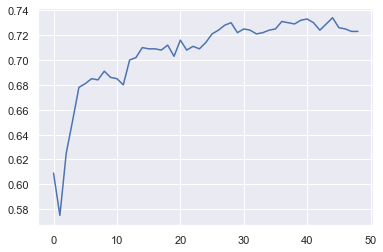

In [53]:
%%time
accuracies = []
for k in range(1, 50):
    knn = KNeighborsClassifier(n_neighbors=k, algorithm='kd_tree')
    knn.fit(x_train, y_train)
    predictions = knn.predict(x_test)
    accuracies.append((predictions == y_test).mean())
plt.plot(accuracies)

CPU times: user 992 ms, sys: 8.16 ms, total: 1e+03 ms
Wall time: 1.02 s


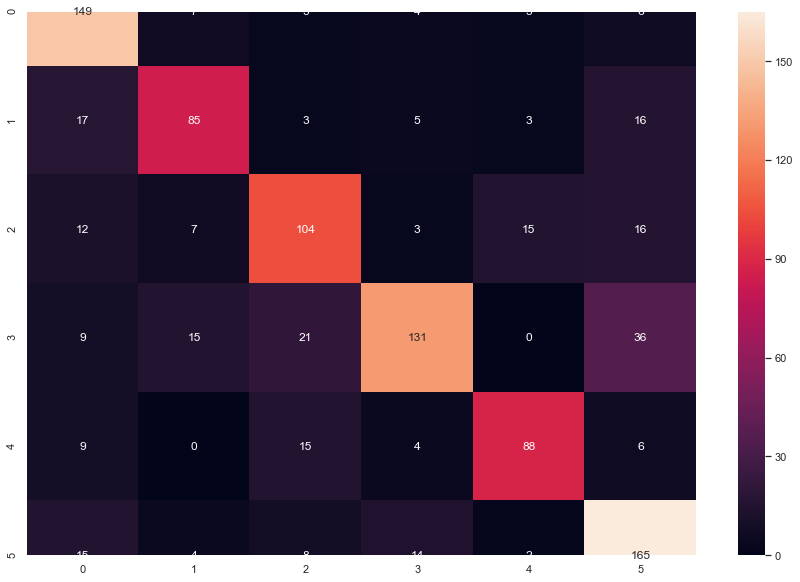

In [64]:
%%time
knn = KNeighborsClassifier(n_neighbors=30, algorithm='kd_tree')
knn.fit(x_train, y_train)
predictions = knn.predict(x_test)
cm = confusion_matrix(y_test, predictions)

plt.figure(figsize = (15,10))
sns.heatmap(cm, annot=True, fmt='d')

# Task

* How many complaints about different products and sub-products?
* What are distributions of the issues and sub-issues? 
* Are there problems with the data?
* What is the relationship between products and sub-products?


# Minimal Deliverable

* EDA + description
* Preprocessing
* training, testing
* hyperparameter tuning + description
* Classification experiments
* Table of who worked on what


# Extra credit

* Different feature extraction and classification methods
* Explore different input/feature combinations
* Extra's? 